In [1]:
from function.VAE_GoM import *

In [2]:
import matplotlib.pyplot as plt 
from IPython.display import clear_output #
import time 
import openturns as ot

On teste le VAE sur une distribution gaussienne tronquée tel que les coordonnées des vecteurs soient supérieurs à un seuil.  

Pour des soucis d'efficacité et de faisabilité on choisit de tronquer seulement sur 2 coordonnées. 

In [3]:
#Simulation of a truncated normal distribution 
def truncatedDistribution(n_samples, dim, mean, variance, lower, higher):
    sd = np.sqrt(variance)
    L = list()
    i = 0 
    while i < n_samples:
        prop = np.random.normal(loc = mean, scale=sd)
        prop_norm = np.linalg.norm(prop[0:2], ord=-np.inf)

        if prop_norm > higher : 
            L.append(prop)
            i += 1
            if i %10 == 0:
                clear_output(wait=True)
                print("boucle %d terminéE" %(i))

    return np.array(L)


In [5]:
#dist = truncatedDistribution(10000, 20, np.zeros(20), np.ones(20), 2, 2)
#dist.shape

boucle 10000 terminéE


(10000, 20)

In [6]:
#np.save('2_component_truncated.npy', dist)

In [3]:
dist = np.load('2_component_truncated.npy')
d = dist.shape[1]

CPU times: total: 5.59 s
Wall time: 6.44 s


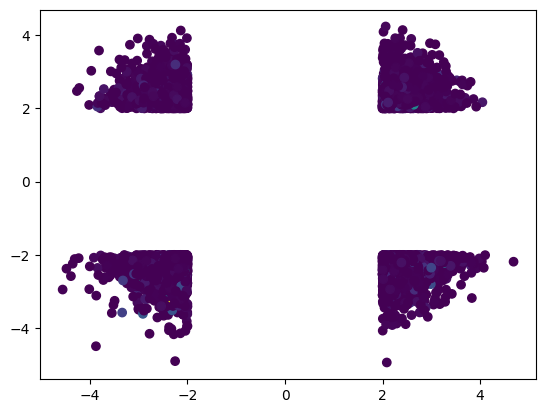

In [5]:
%%time
kde = sp.gaussian_kde(dist.T)
plt.scatter(dist[:,0], dist[:,1], c = kde(dist.T));

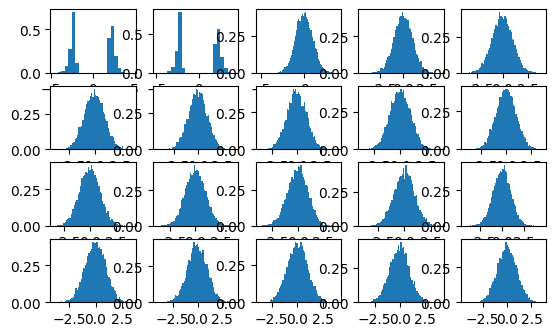

In [4]:
for i in range(d):
    plt.subplot(5,5,i+1)
    plt.hist(dist[:, i],bins= 'auto', density=True);

In [9]:
means = tf.Variable(tf.random.normal([6, 2]) , dtype=tf.float32)
logvars = tf.Variable(tf.random.normal([6, 2]), dtype=tf.float32)
w = tf.Variable(tf.ones([1,6]), dtype=tf.float32)
w = tf.nn.softmax(w, axis=1)
print(w)

indexes = tf.random.categorical(tf.math.log(w), 1)
print(indexes[0,0])
eps = tf.random.normal((1, 2))
idx = indexes
z = means[ idx[0]] + eps * tf.exp(0.5*logvars[idx[0]])
#z.append(z_i)
#zz = tf.stack(z, axis=0)
z

tf.Tensor([[0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]], shape=(1, 6), dtype=float32)
tf.Tensor(3, shape=(), dtype=int64)


TypeError: Only integers, slices (`:`), ellipsis (`...`), tf.newaxis (`None`) and scalar tf.int32/tf.int64 tensors are valid indices, got <tf.Tensor: shape=(1,), dtype=int64, numpy=array([3], dtype=int64)>

In [5]:
mixture = MoGPrior(2, 16)
mixture.call()

<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[-0.6792153, -0.4365251]], dtype=float32)>

In [6]:
encoder = Encoder(d,2,16)
decoder = Decoder(d,2)
vae = VAE(encoder, decoder)

In [7]:
vae.compile(optimizer= tf.keras.optimizers.Adam(learning_rate= 0.01))
history = vae.fit(dist,epochs=20,
    batch_size=10,
    shuffle=True)

Epoch 1/20


ValueError: Exception encountered when calling Sampling.call().

[1mtf.function only supports singleton tf.Variables created on the first call. Make sure the tf.Variable is only created once or created outside tf.function. See https://www.tensorflow.org/guide/function#creating_tfvariables for more information.[0m

Arguments received by Sampling.call():
  • inputs=['tf.Tensor(shape=(10, 2), dtype=float32)', 'tf.Tensor(shape=(10, 2), dtype=float32)']

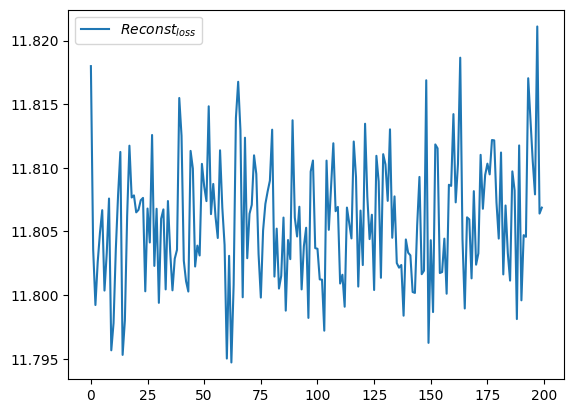

In [72]:
#plt.plot(history.history['kl_loss'], label = r'$KL_{loss}$')
#plt.plot(history.history['loss'], label = r'$Total_{loss}$')
plt.plot(history.history['reconstruction_loss'], label = r'$Reconst_{loss}$')
plt.legend()

In [61]:
_,_, z = encoder(dist)
mean_x, log_var_x = decoder(z) #we get each mean and log variance of the several distribution then we sample from it 

sample = np.random.normal(loc=mean_x, scale= tf.exp(log_var_x/2))

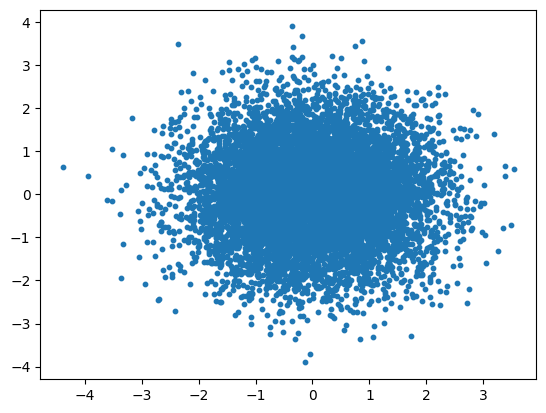

In [62]:
plt.scatter(z[:, 0], z[:, 1], s = 10)

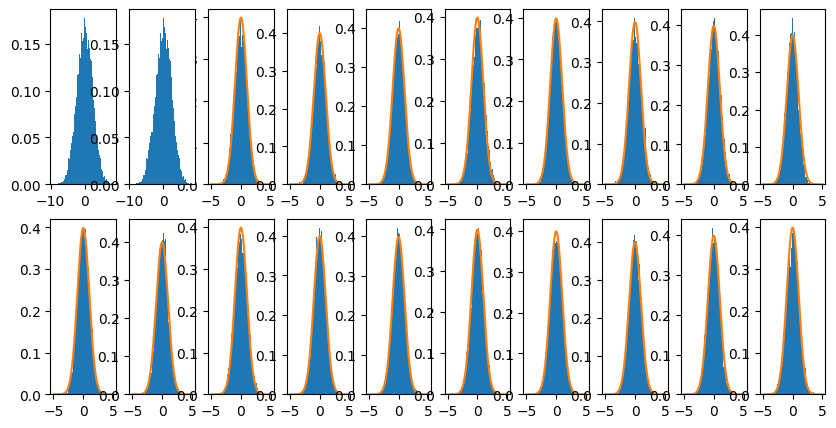

In [65]:
plt.figure(figsize=(10,5))
col = int(d/2)
xx = np.linspace(-5,5, 1000)
distr1 = ot.TruncatedDistribution(ot.Normal(1), 2, ot.TruncatedDistribution.LOWER)
distr2 = ot.TruncatedDistribution(ot.Normal(1), 2, ot.TruncatedDistribution.LOWER)
for i in range(2,d):
    plt.subplot(2, col, i+1)
    plt.hist(sample[:,i], density=True, bins = 'auto');
    plt.plot(xx, sp.norm.pdf(xx))
plt.subplot(2, col, 1)
plt.hist(sample[:,0], density=True, bins = 'auto');
#plt.plot(xx, distr1.computePDF(xx.reshape((-1,1))))

plt.subplot(2, col, 2)
plt.hist(sample[:,0], density=True, bins = 'auto');
#plt.plot(xx, distr2.computePDF(xx.reshape((-1,1))))

In [19]:
print(f"La moyenne empirique de la  1er composante {np.mean(mean_x, axis=0)[0]} et la moyenne théorique  {sp.norm.pdf(2)/(1-sp.norm.cdf(2))}" )
print(f"Moyenne empirique {np.mean(tf.exp(log_var_x/2), axis = 0 )[0]}, moyenne théorique {np.sqrt(1 - sp.norm.pdf(2)/(1-sp.norm.cdf(2)) * (sp.norm.pdf(2)/(1-sp.norm.cdf(2)) - 2))}")

La moyenne empirique de la  1er composante 2.3693594932556152 et la moyenne théorique  2.373215532822841
Moyenne empirique 0.3409057855606079, moyenne théorique 0.33805191970181275


In [76]:
tf.random.normal(shape=(2,3) * 2)

<tf.Tensor: shape=(2, 3, 2, 3), dtype=float32, numpy=
array([[[[-0.2077472 ,  0.8372502 ,  0.7636042 ],
         [-0.26769003, -0.83538824, -1.6091968 ]],

        [[-0.09235588, -1.1677388 ,  0.07305634],
         [ 0.02604854, -0.99655217, -0.01910271]],

        [[ 0.532357  ,  0.28728956, -0.4153961 ],
         [-0.24397027, -0.04774787, -1.2111464 ]]],


       [[[ 1.6499565 ,  1.22523   , -0.16582148],
         [-1.2989105 ,  0.9550175 , -0.84824306]],

        [[ 1.0888371 , -0.99390435, -0.05806948],
         [ 0.37919864, -0.54539394, -1.449325  ]],

        [[-0.0414882 , -0.60569334,  0.14872912],
         [-0.15472518,  0.7569418 , -1.3987193 ]]]], dtype=float32)>